In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer

# Training DP-MLP to solve Sparse Parity

This setup involves 30 bits as input and 10 neurons in the hidden layer of the MLP.
The first step was to find the gradientClipping following the ClipSearch method (https://jair.org/index.php/jair/article/view/14649/26952 page 1160)
Then sweeping with multiple noise multipliers to find the optimal one. 

More information in Article "How to DP-fy ML: A Practical Guide to Machine Learning with Differential Privacy" (https://jair.org/index.php/jair/article/view/14649/26952) page 1162.

In [2]:

train_size = 1000       #Max value tested: 3000
test_size = 1500       #Max value tested: 3500
l1_lambda = 1e-4 
gradient_clipping = 0.3
learning_rate = 0.03
batch_size = 32


unique_binary_strings = set()
while len(unique_binary_strings) < train_size + test_size:
    binary_string = tuple(np.random.randint(2, size=30))
    unique_binary_strings.add(binary_string)

inputs = np.array(list(unique_binary_strings), dtype=np.float32)
outputs = np.sum(inputs[:, :3], axis=-1) % 2


ones_column = np.ones((inputs.shape[0], 1), dtype=np.float32)
inputs = np.concatenate((inputs, ones_column), axis=1)

indices = np.random.permutation(len(inputs))
split_idx = int(train_size)
X_train, y_train = inputs[indices[:split_idx]], outputs[indices[:split_idx]]
X_eval, y_eval = inputs[indices[split_idx:]], outputs[indices[split_idx:]]


In [ ]:


noise_multipliers = [0.0044672234855, 0.0084672234855, 0.005, 0.008, 0,33, 5, 10]
meanAccuracyResults = []
for nm in noise_multipliers:
    model = Sequential()
    model.add(Dense(10, input_dim=31, activation='relu', kernel_regularizer=l1(l1_lambda)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(l1_lambda)))

    # DP-Adam optimizer
    optimizer = DPKerasSGDOptimizer(
        l2_norm_clip=gradient_clipping,       # Gradient clipping
        noise_multiplier=nm,   # Noise for privacy
        num_microbatches=1,    
        learning_rate=learning_rate    # Learning rate for SGD
    )

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    class WeightTrackingCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            self.train_accuracies = []
            self.test_accuracies = []
            self.weights_over_time = []
            self.noise_levels = []
            self.stepsRequired100 = 0

        def on_epoch_end(self, epoch, logs=None):
            self.train_accuracies.append(logs.get('accuracy'))
            self.test_accuracies.append(logs.get('val_accuracy'))
        
            weights, biases = self.model.layers[0].get_weights()
            self.weights_over_time.append(weights)
            noise_level = nm * gradient_clipping * batch_size
            self.noise_levels.append(noise_level)


    weight_tracking_callback = WeightTrackingCallback()


    history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, 
                        validation_data=(X_eval, y_eval), 
                        callbacks=[weight_tracking_callback])


    loss, accuracy = model.evaluate(X_eval, y_eval)

    #Mean in last 50 epochs
    meanAccuracy = np.mean(weight_tracking_callback.test_accuracies[-50:])
    meanAccuracyResults.append(meanAccuracy)
    weight_tracking_callback.test_accuracies = []



print(f"Test Accuracy: {accuracy * 100:.2f}%")




Epoch 1/100

32/32 [==============================] - 2s 10ms/step - loss: 0.7401 - accuracy: 0.4960 - val_loss: 0.7282 - val_accuracy: 0.5133
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7276 - accuracy: 0.5030 - val_loss: 0.7222 - val_accuracy: 0.5100
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.7203 - accuracy: 0.5110 - val_loss: 0.7191 - val_accuracy: 0.5100
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7156 - accuracy: 0.5140 - val_loss: 0.7167 - val_accuracy: 0.5127
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.7116 - accuracy: 0.5160 - val_loss: 0.7155 - val_accuracy: 0.5040
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7085 - accuracy: 0.5250 - val_loss: 0.7138 - val_accuracy: 0.5073
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.7064 - accuracy: 0.5210 - val_loss: 0.7129 - val_accuracy: 0.5127
Epoch 8/10

KeyboardInterrupt: 

C:\Users\santi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\santi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


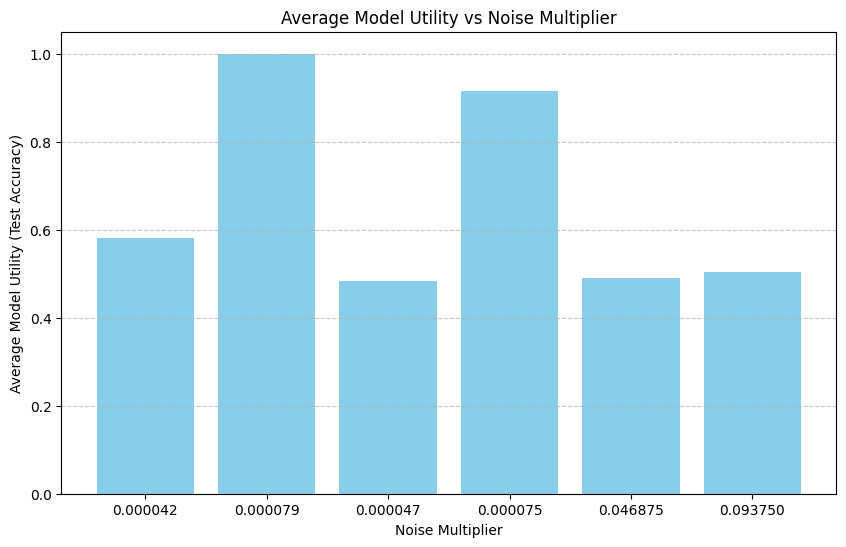

In [ ]:
unique_noise_multipliers = noise_multipliers

#sigmaStar is array of noise*gradient / batchSize for each noiseMultiplier
sigmaStar = np.array([(nm * gradient_clipping)/batch_size for nm in unique_noise_multipliers])
mean_test_accuracies = np.mean(weight_tracking_callback.test_accuracies, axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(len(sigmaStar)), meanAccuracyResults, color='skyblue')
plt.xticks(range(len(sigmaStar)), [f'{nm:.6f}' for nm in sigmaStar])
plt.xlabel('Noise Multiplier')
plt.ylabel('Average Model Utility (Test Accuracy)')
plt.title('Average Model Utility vs Noise Multiplier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [4]:
from tensorflow_privacy import compute_dp_sgd_privacy_statement



train_size = 1000000
num_epochs = 100                            
delta = 1/(train_size)                       # Tolerance level for privacy loss
used_microbatching = False
batch_size = 1
noise_multiplier = 0.33         

# Generate the privacy statement
privacy_statement = compute_dp_sgd_privacy_statement(
    number_of_examples=train_size,
    batch_size=batch_size,
    num_epochs=num_epochs,
    noise_multiplier=noise_multiplier,
    delta=delta,
    max_examples_per_user=1,
    used_microbatching=used_microbatching
)

print(privacy_statement)

DP-SGD performed over 1000000 examples with 1 examples per iteration, noise
multiplier 0.33 for 100 epochs without microbatching, and at most 1 examples per
user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-06 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:       617.338
    Epsilon assuming Poisson sampling (*):                     10.725

User-level DP with add-or-remove-one adjacency at delta = 1e-06 computed using
RDP accounting and group privacy:
    Epsilon with each example occurring once per epoch:       617.338
    Epsilon assuming Poisson sampling (*):                     10.725

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data orde

In [ ]:
for epoch, accuracy in enumerate(weight_tracking_callback.test_accuracies):
    if accuracy == 1.0:  # Check if accuracy is 100% (1.0 in normalized form)
        print(f"First occurrence of 100% accuracy at epoch {epoch + 1}")
        break
else:
    print("100% accuracy was not reached.")

100% accuracy was not reached.


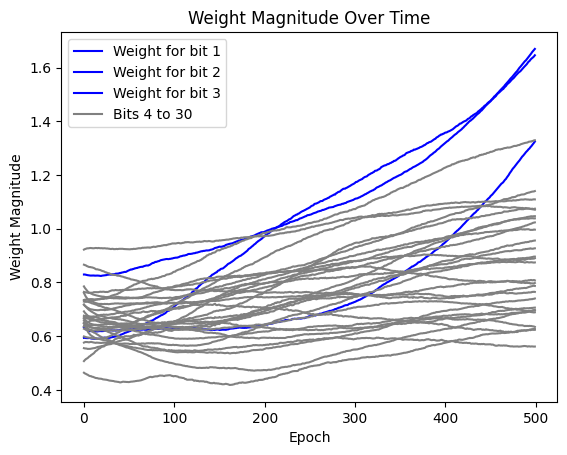

In [ ]:
weights_over_time = np.array(weight_tracking_callback.weights_over_time)


for i in range(3):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), label=f'Weight for bit {i+1}', color='blue')


for i in range(3, 30):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), color='gray')


plt.title('Weight Magnitude Over Time')
plt.xlabel('Epoch')
plt.ylabel('Weight Magnitude')


plt.plot([], [], color='blue')
plt.plot([], [], color='gray', label='Bits 4 to 30')
plt.legend()

plt.show()


* Sigma Star selected: 0.000078
* Noise_multiplier selected: 0.33


Sweeps to get the right data_size to reach 100% accuracy



In [ ]:

for size in [1000, 2000, 5000, 9000]:

    train_size = 1000 + size       
    test_size = 1500 + size     
    l1_lambda = 1e-4   
    noise_multiplier = 0.33
    gradient_clipping = 0.3
    learning_rate = 0.03
    batch_size = 1
    epochs = 100


    unique_binary_strings = set()
    while len(unique_binary_strings) < train_size + test_size:
        binary_string = tuple(np.random.randint(2, size=30))
        unique_binary_strings.add(binary_string)

    inputs = np.array(list(unique_binary_strings), dtype=np.float32)
    outputs = np.sum(inputs[:, :3], axis=-1) % 2


    ones_column = np.ones((inputs.shape[0], 1), dtype=np.float32)
    inputs = np.concatenate((inputs, ones_column), axis=1)

    indices = np.random.permutation(len(inputs))
    split_idx = int(train_size)
    X_train, y_train = inputs[indices[:split_idx]], outputs[indices[:split_idx]]
    X_eval, y_eval = inputs[indices[split_idx:]], outputs[indices[split_idx:]]

    model = Sequential()
    model.add(Dense(10, input_dim=31, activation='relu', kernel_regularizer=l1(l1_lambda)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(l1_lambda)))
 
    # DP-Adam optimizer
    optimizer = DPKerasSGDOptimizer(
        l2_norm_clip=gradient_clipping,       # Gradient clipping
        noise_multiplier=noise_multiplier,   # Noise for privacy
        num_microbatches=1,    
        learning_rate=learning_rate    # Learning rate for SGD
    )

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    class WeightTrackingCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            self.train_accuracies = []
            self.test_accuracies = []
            self.weights_over_time = []
            self.noise_levels = []
            self.stepsRequired100 = 0

        def on_epoch_end(self, epoch, logs=None):
            self.train_accuracies.append(logs.get('accuracy'))
            self.test_accuracies.append(logs.get('val_accuracy'))
        
            weights, biases = self.model.layers[0].get_weights()
            self.weights_over_time.append(weights)
            noise_level = noise_multiplier * gradient_clipping * batch_size
            self.noise_levels.append(noise_level)


    weight_tracking_callback = WeightTrackingCallback()


    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_eval, y_eval), 
                        callbacks=[weight_tracking_callback])


    loss, accuracy = model.evaluate(X_eval, y_eval)

    meanAccuracy = np.mean(weight_tracking_callback.test_accuracies)
    meanAccuracyResults.append(meanAccuracy)



    print(f"Test Accuracy: {accuracy * 100:.2f}%")



NameError: name 'size' is not defined

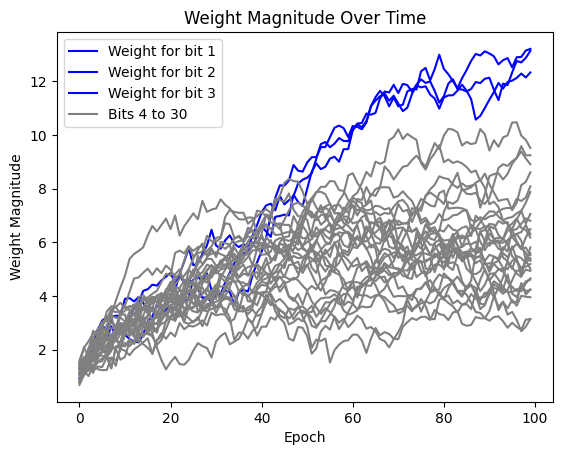

In [ ]:
weights_over_time = np.array(weight_tracking_callback.weights_over_time)


for i in range(3):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), label=f'Weight for bit {i+1}', color='blue')


for i in range(3, 30):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), color='gray')


plt.title('Weight Magnitude Over Time')
plt.xlabel('Epoch')
plt.ylabel('Weight Magnitude')


plt.plot([], [], color='blue')
plt.plot([], [], color='gray', label='Bits 4 to 30')
plt.legend()

plt.show()


In [ ]:
#Mean of last 10 epochs
print(np.mean(weight_tracking_callback.test_accuracies))

[0.5047619342803955, 0.4996190369129181, 0.5025714039802551, 0.5082857012748718, 0.5065714120864868, 0.5014285445213318, 0.4977142810821533, 0.5130476355552673, 0.5080952644348145, 0.5035238265991211, 0.5113333463668823, 0.5117142796516418, 0.513619065284729, 0.5504761934280396, 0.584857165813446, 0.6865714192390442, 0.7391428351402283, 0.7467619180679321, 0.7519047856330872, 0.7540000081062317, 0.753333330154419, 0.7540000081062317, 0.7540952563285828, 0.7566666603088379, 0.756761908531189, 0.7651428580284119, 0.7938095331192017, 0.829714298248291, 0.8595238327980042, 0.8775237798690796, 0.87971431016922, 0.8790476322174072, 0.878761887550354, 0.8759999871253967, 0.8759999871253967, 0.8793333172798157, 0.8781904578208923, 0.87971431016922, 0.8783809542655945, 0.8778095245361328, 0.8792380690574646, 0.8780952095985413, 0.874666690826416, 0.8789523839950562, 0.8783809542655945, 0.87971431016922, 0.877047598361969, 0.8781904578208923, 0.8781904578208923, 0.876380980014801, 0.879238069057

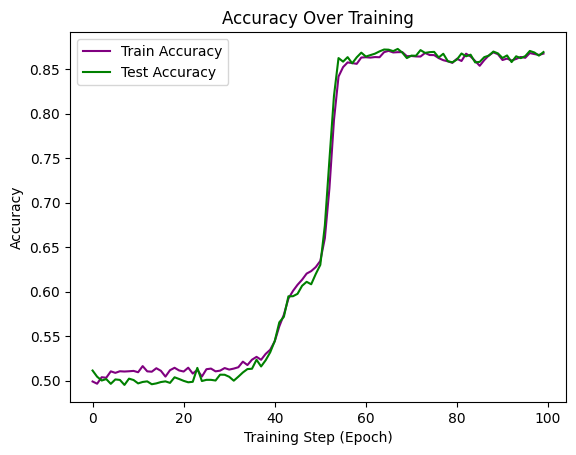

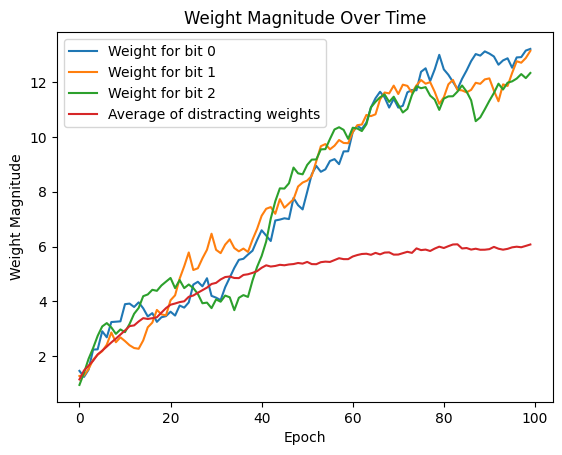

In [ ]:

plt.plot(weight_tracking_callback.train_accuracies, label='Train Accuracy', color='purple')
plt.plot(weight_tracking_callback.test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy Over Training')
plt.xlabel('Training Step (Epoch)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

weights_over_time = np.array(weight_tracking_callback.weights_over_time)
for i in range(3):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), label=f'Weight for bit {i}')
plt.plot(np.linalg.norm(weights_over_time[:, 3:, :], axis=-1).mean(axis=1), label='Average of distracting weights')
plt.title('Weight Magnitude Over Time')
plt.xlabel('Epoch')
plt.ylabel('Weight Magnitude')
plt.legend()
plt.show()

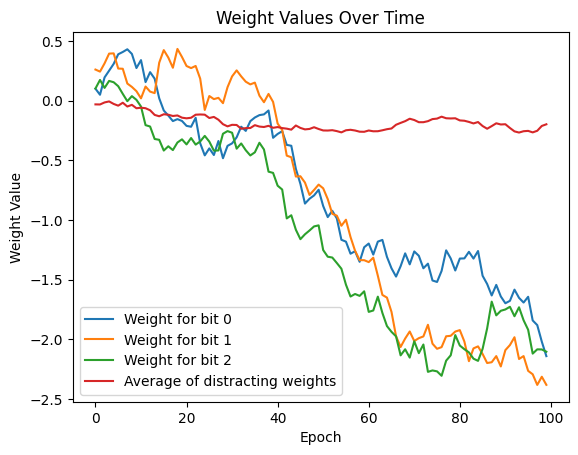

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

weights_over_time = np.array(weight_tracking_callback.weights_over_time)

# Plot the weight values for the first 3 bits over time
for i in range(3):
    plt.plot(weights_over_time[:, i, :].mean(axis=-1), label=f'Weight for bit {i}')

# Plot the average of distracting weights (from bit 3 onwards)
plt.plot(weights_over_time[:, 3:, :].mean(axis=(1, 2)), label='Average of distracting weights')

plt.title('Weight Values Over Time')
plt.xlabel('Epoch')
plt.ylabel('Weight Value')
plt.legend()

plt.show()


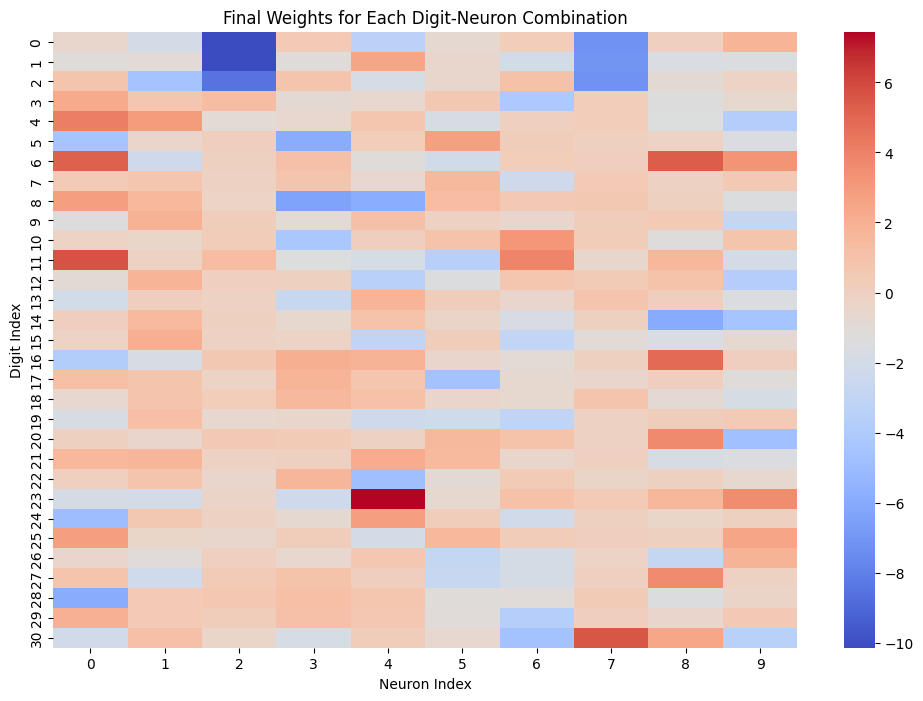

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Extract weights from the final epoch (last entry in weights_over_time)
final_weights = weights_over_time[-1, :, :]  # Shape will be (31, 30)

# Plot the heatmap for final weights of each digit-neuron combination
plt.figure(figsize=(12, 8))
sns.heatmap(final_weights, annot=False, cmap="coolwarm", cbar=True)
plt.title('Final Weights for Each Digit-Neuron Combination')
plt.xlabel('Neuron Index')
plt.ylabel('Digit Index')
plt.show()


## Results


(10, 1e^-6)-DP with 100% accuracy achieved with parameters:


train_size = 10000     
test_size = 10500   
l1_lambda = 1e-4   
noise_multiplier = 0.33
gradient_clipping = 0.3
learning_rate = 0.03
batch_size = 1
epochs = 100

